<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Reference-data" data-toc-modified-id="Reference-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference data</a></span></li><li><span><a href="#Load-most-recent-data" data-toc-modified-id="Load-most-recent-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load most recent data</a></span><ul class="toc-item"><li><span><a href="#CPI-by-country-month" data-toc-modified-id="CPI-by-country-month-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CPI by country-month</a></span></li><li><span><a href="#Exchange-rates" data-toc-modified-id="Exchange-rates-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Exchange rates</a></span></li><li><span><a href="#Merge-all" data-toc-modified-id="Merge-all-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Merge all</a></span></li></ul></li></ul></div>


## Import


In [2]:
import io

import datetime
import matplotlib
from matplotlib import pyplot as plt

# import numpy as np
import pandas as pd
import requests

# set pandas options
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

# set plotting style
plt.style.use("./plotting.mplstyle")


# common legend function
def add_legend(title: str = None) -> None:
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title=title)

## Reference data

Available IFS code lists: `['CL_FREQ', 'CL_AREA_IFS', 'CL_INDICATOR_IFS']`


In [3]:
# country codes -> names

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CodeList/"
url += "CL_AREA_IFS"
codelist_data = requests.get(url).json()

# to dataframe

tupes = []
for row in codelist_data["Structure"]["CodeLists"]["CodeList"]["Code"]:
    tupes.append((row["@value"], row["Description"]["#text"]))
ref_areas = pd.DataFrame(tupes, columns=["ref_area", "name"])
ref_areas.columns = ["ref_area", "country_name"]
ref_areas

,ref_area,country_name
0,AF,Afghanistan
1,AL,Albania
2,DZ,Algeria
3,AD,Andorra
4,AO,Angola
...,...,...
266,1C_SRF,SRF Countries
267,F6,Sub-Saharan Africa
268,7A,WAEMU (West African Economic and Monetary Union)
269,A10,Western Hemisphere


In [127]:
# available databases

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/Dataflow"
data = requests.get(f"{url}").json()
# data

In [128]:
database_id = "IFS"
url = f"http://dataservices.imf.org/REST/SDMX_JSON.svc/DataStructure/{database_id}"
data = requests.get(f"{url}").json()
# data

In [4]:
# ppp adjustment

ppp = pd.read_csv("./ppp2020.csv")
ppp["ppp_2020"] = ppp.ppp_2020.astype(float)
ppp.head()

,country_name,ppp_2020,country_code
0,Afghanistan,19.120000,AFG
1,Albania,42.410000,ALB
2,Algeria,37.020000,DZA
3,Angola,159.350000,AGO
4,Anguilla,2.294516,AIA


## Load most recent data


### CPI by country-month

2010 average for each country = 100


In [5]:
def adjust_country_names(
    df: pd.DataFrame, name_var: str = "country_name"
) -> pd.DataFrame:
    """
    Takes df and changes country names to match those in the ppp dataframe.
    """

    # adjust country names as needed
    for old, new in zip(
        [
            "Hong Kong, China",
            "Türkiye",
            "Kosovo, Republic of",
            "Saint Kitts and Nevis",
            "Sao Tome and Principe",
            "The Bahamas",
            "Brunei",
            "Republic of the Congo",
            "Democratic Republic of the Congo",
            "Congo, the Democratic Republic of the",
            "Cote d Ivoire",
            "Kingdom of Denmark",
            "The Gambia",
            "Hong Kong",
            "Iran",
            "South Korea",
            "Laos",
            "Macau",
            "Moldova",
            "Burma (Myanmar)",
            "Russia",
            "Taiwan",
            "Tanzania",
            "Vietnam",
        ],
        [
            "Hong Kong SAR, China",
            "Turkey",
            "Kosovo",
            "St. Kitts and Nevis",
            "São Tomé and Principe",
            "Bahamas",
            "Brunei Darussalam",
            "Congo",
            "Congo",
            "Congo",
            "Cote d`Ivoire",
            "Denmark",
            "Gambia",
            "Hong Kong SAR, China",
            "Iran, Islamic Republic of",
            "Korea, Republic of",
            "Lao People`s Democratic Republic",
            "Macao",
            "Moldova, Republic of",
            "Myanmar",
            "Russian Federation",
            "Taiwan, Province of China",
            "Tanzania, United Republic of",
            "Viet Nam",
        ],
    ):
        df.loc[df[name_var] == old, name_var] = new

    return df


for df in [ref_areas, ppp]:
    df = adjust_country_names(df)

In [6]:
# get json
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/"
key = "CompactData/IFS/M..PCPI_IX.?startPeriod=2000"
data = requests.get(f"{url}{key}").json()["CompactData"]["DataSet"]

# convert to df
cpi = pd.DataFrame()
for row in data["Series"]:
    ref_area = row["@REF_AREA"]
    try:
        obs = row["Obs"]
    except:
        print(ref_area)
        continue
    if len(obs) < 3:
        print(ref_area)
        continue
    dftmp = pd.DataFrame.from_dict(obs)
    try:
        dftmp = dftmp[["@TIME_PERIOD", "@OBS_VALUE"]]
    except:
        print(ref_area)
        continue
    dftmp.columns = ["date", "value"]
    dftmp["ref_area"] = ref_area
    cpi = pd.concat([cpi, dftmp])

# merge ref area name
cpi = cpi.merge(ref_areas, on="ref_area", how="left")
cpi.drop(columns="ref_area", inplace=True)

# adjust country names as needed
cpi = adjust_country_names(cpi)

# convert types
cpi["date"] = pd.to_datetime(cpi.date)
cpi["value"] = cpi.value.astype(float)

cpi.head()

CSH
YUC
BZ
AR
TW
AN
7A


,date,value,country_name
0,2000-01-01,83.812411,Bahrain
1,2000-02-01,83.648714,Bahrain
2,2000-03-01,84.221651,Bahrain
3,2000-04-01,83.812411,Bahrain
4,2000-05-01,84.057955,Bahrain


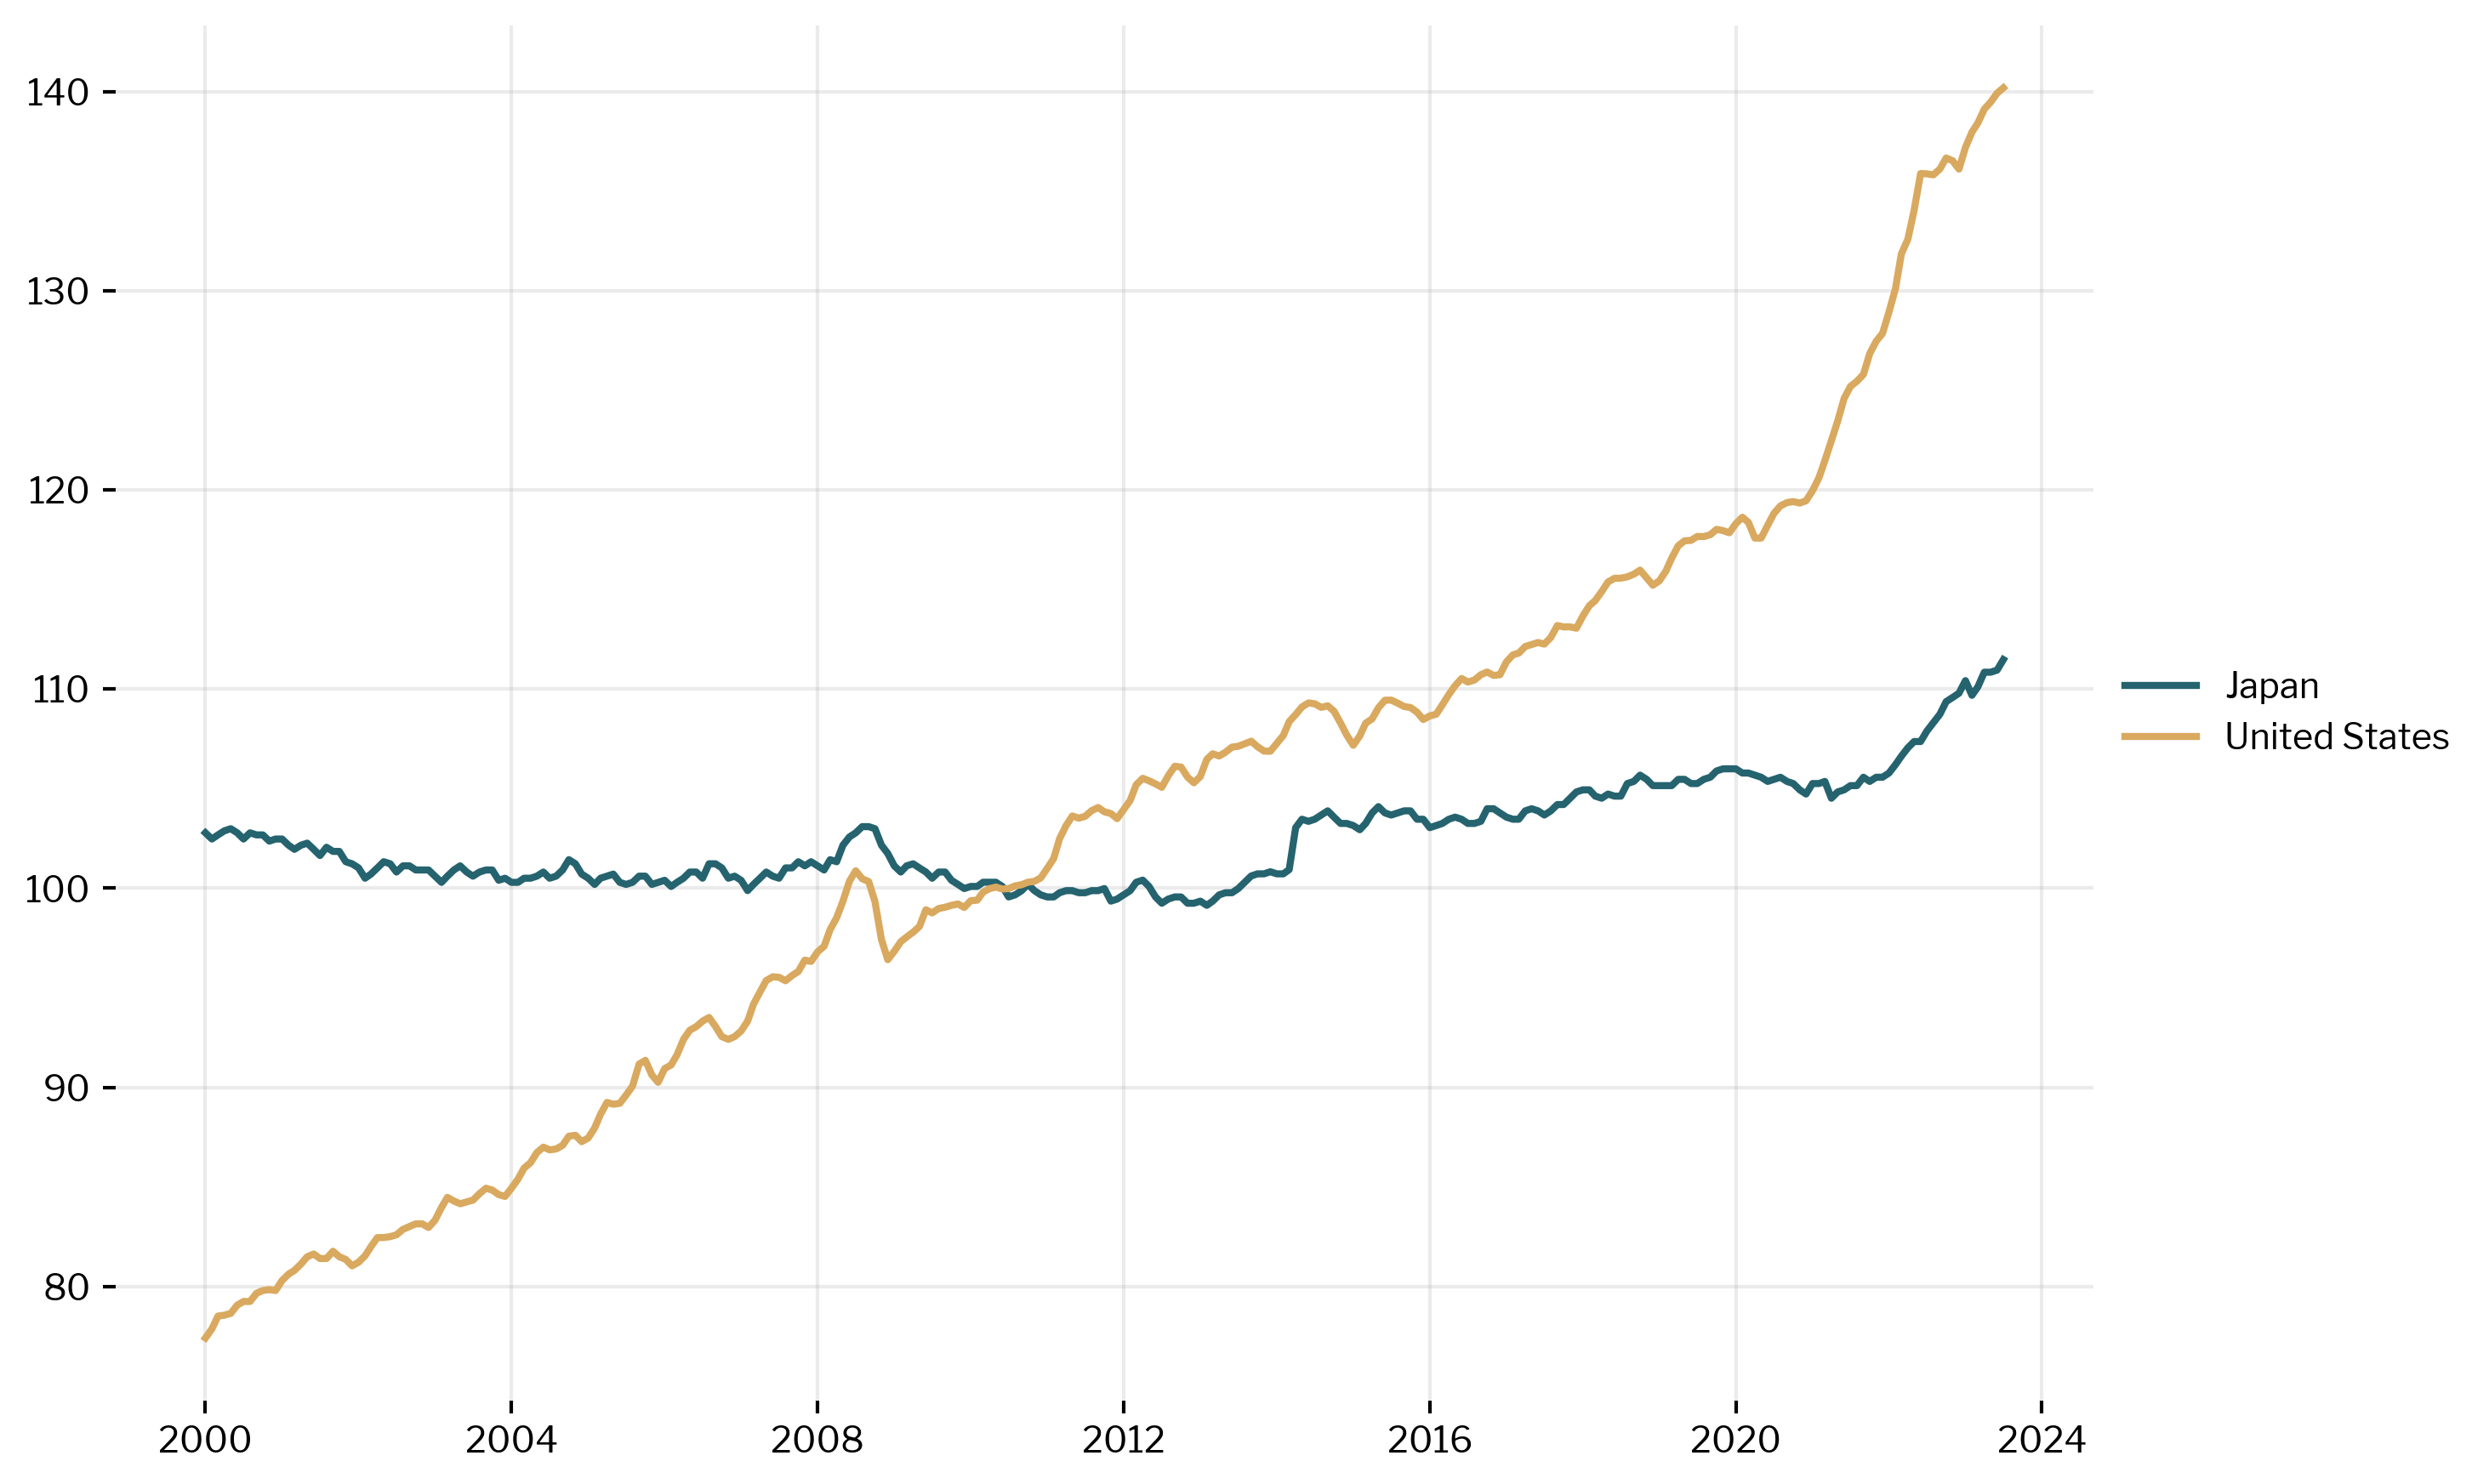

In [211]:
# plot example

_, ax = plt.subplots(figsize=(10, 7))

for country in ["Japan", "United States"]:
    dfsub = cpi.loc[cpi.country_name == country]
    plt.plot(dfsub.date, dfsub.value, label=country)

add_legend()

### Exchange rates


In [7]:
# get json
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/"
key = "CompactData/IFS/M..ENDA_XDC_USD_RATE.?startPeriod=2000"
data = requests.get(f"{url}{key}").json()["CompactData"]["DataSet"]

# convert to df
exr = pd.DataFrame()
for row in data["Series"]:
    ref_area = row["@REF_AREA"]
    try:
        obs = row["Obs"]
    except:
        print(ref_area)
        continue
    if len(obs) < 3:
        print(ref_area)
        continue
    dftmp = pd.DataFrame.from_dict(obs)
    try:
        dftmp = dftmp[["@TIME_PERIOD", "@OBS_VALUE"]]
    except:
        print(ref_area)
        continue
    dftmp.columns = ["date", "value"]
    dftmp["ref_area"] = ref_area
    exr = pd.concat([exr, dftmp])

# merge ref area name
exr = exr.merge(ref_areas, on="ref_area", how="left")
exr.drop(columns="ref_area", inplace=True)

# adjust country names as needed
exr = adjust_country_names(exr)

# convert types
exr["date"] = pd.to_datetime(exr.date)
exr["value"] = exr.value.astype(float)

exr.head()

PT
AT
FI
NL
YUC
R1
GF
DE
ES
CU
GP
IT
LU
RE
1C_459
FR
IE
CSH
BE
MQ
1C_473
PM
SUH
DE2


,date,value,country_name
0,2000-01-01,1.0,Ecuador
1,2000-02-01,1.0,Ecuador
2,2000-03-01,1.0,Ecuador
3,2000-04-01,1.0,Ecuador
4,2000-05-01,1.0,Ecuador


Text(0.0, 1.0, 'Own currency per dollar')

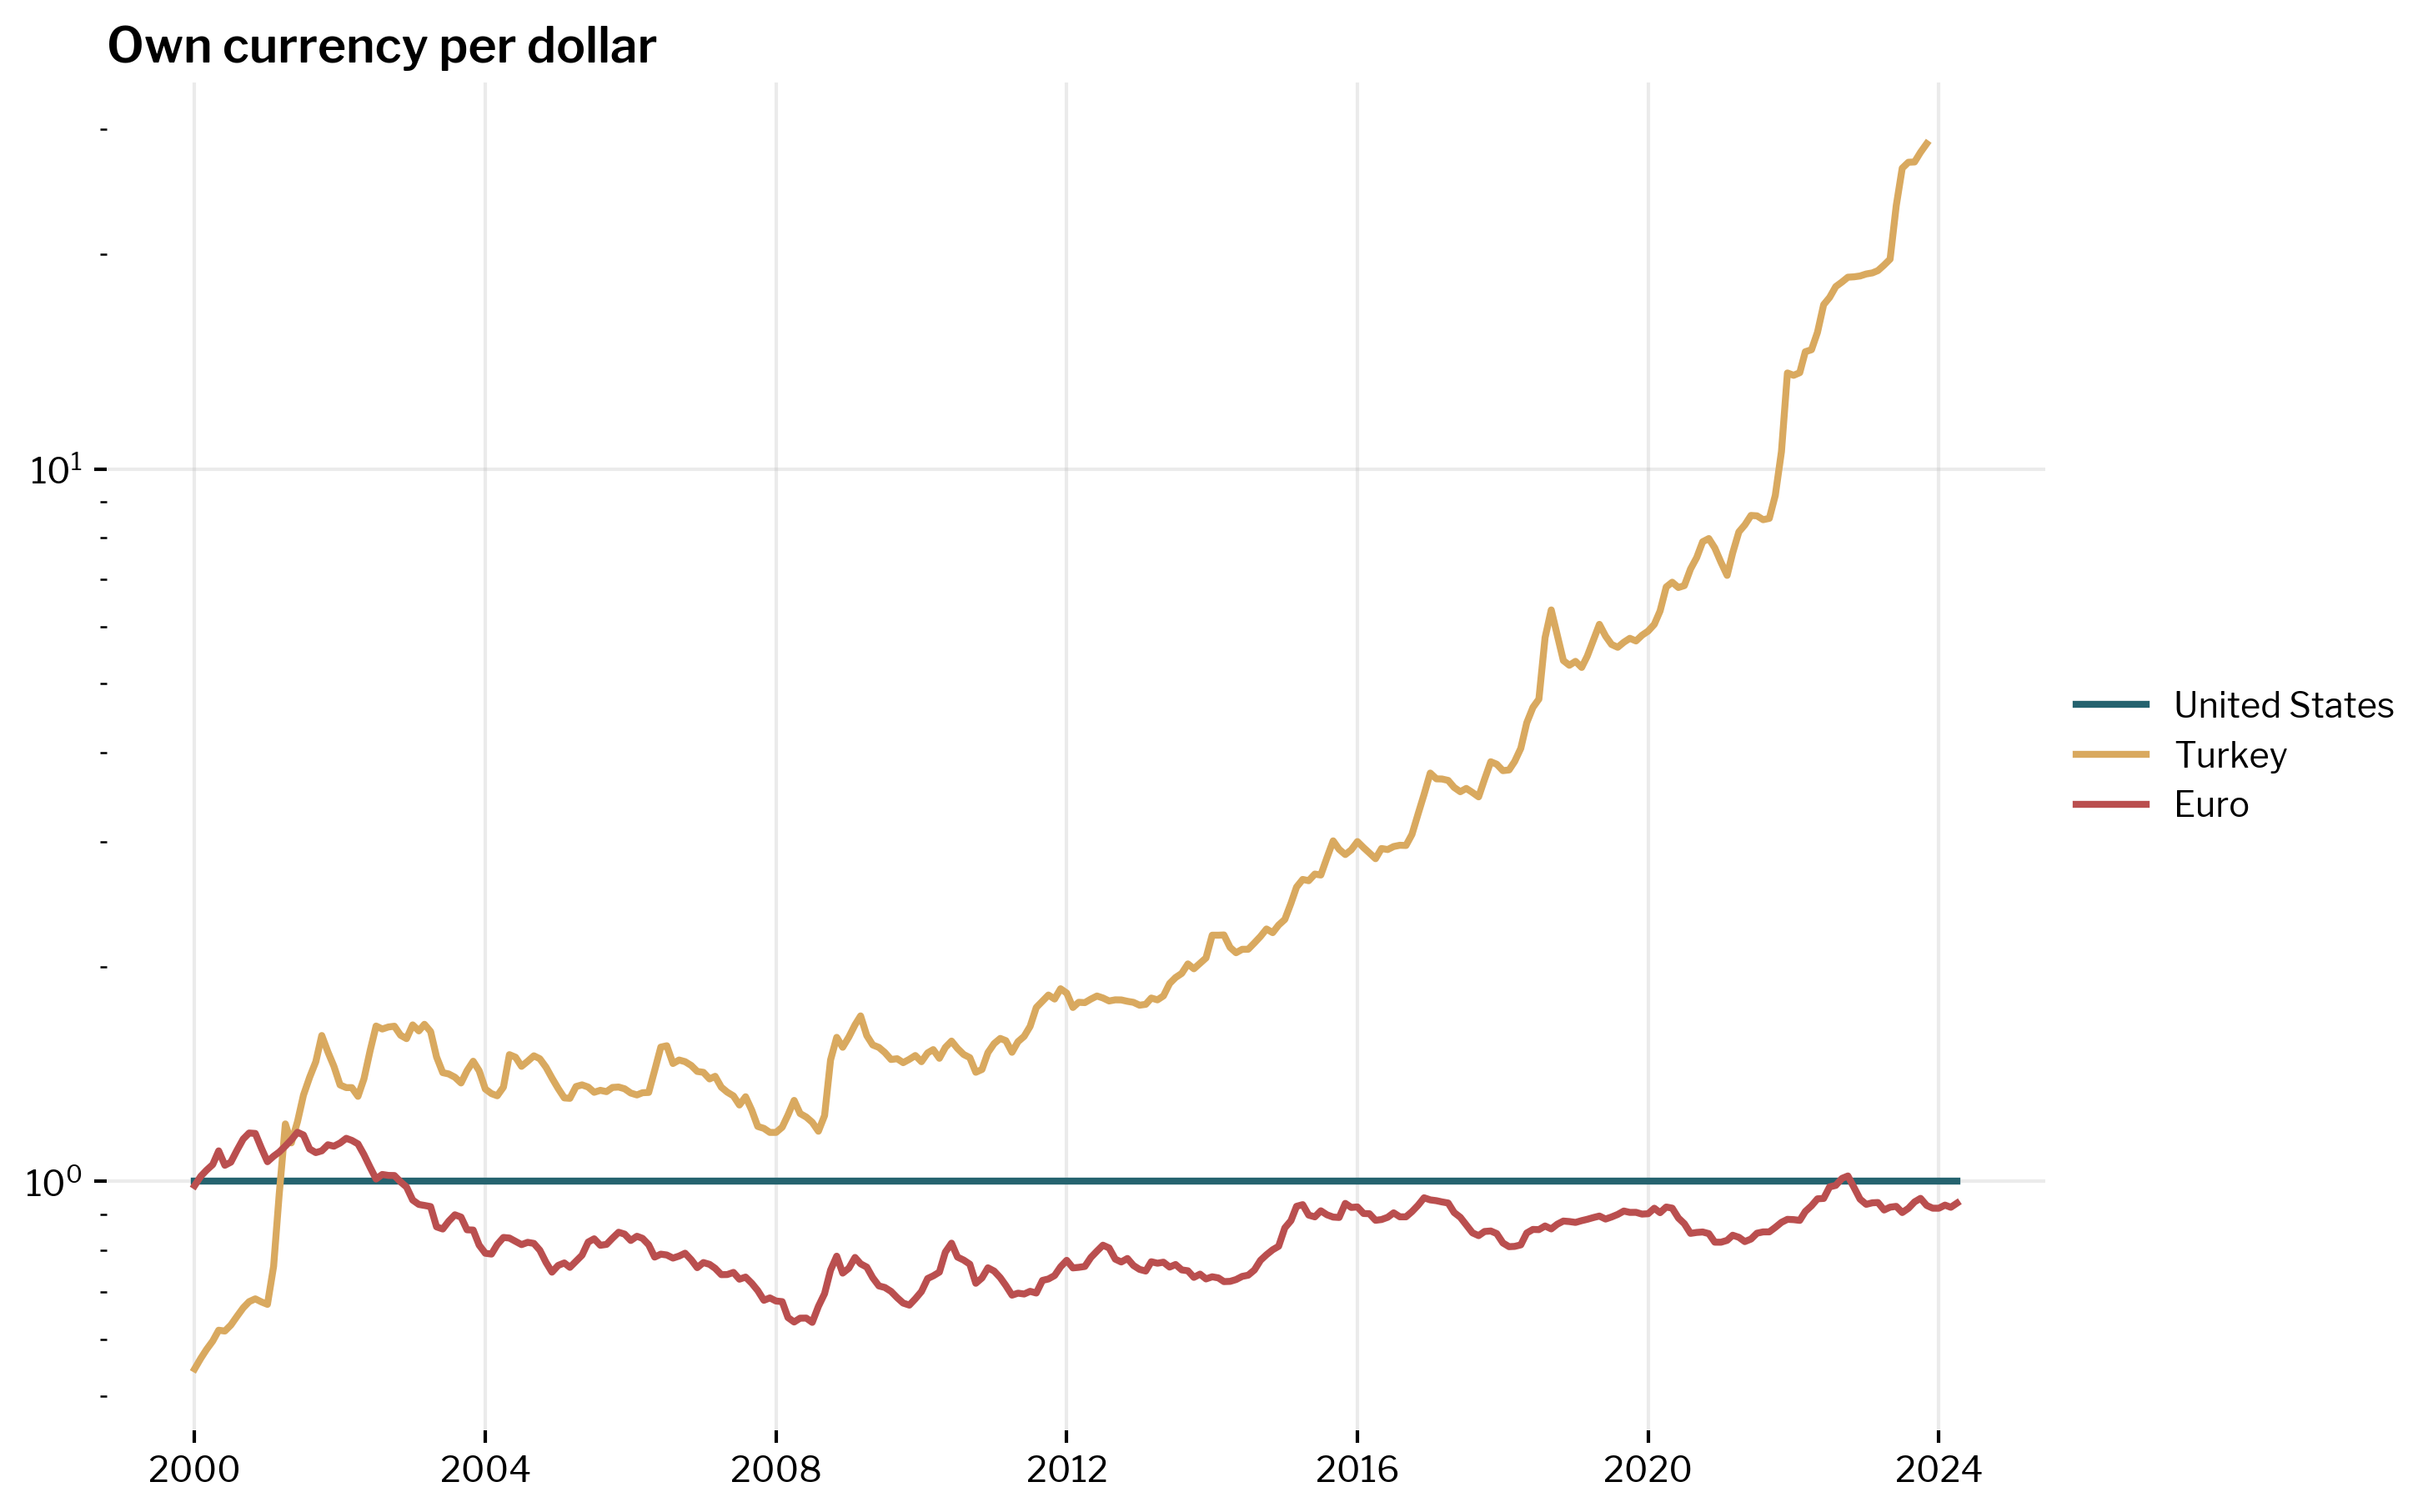

In [8]:
# plot example

_, ax = plt.subplots(figsize=(10, 7))

# log yaxis
ax.set_yscale("log")

for country in ["United States", "Turkey", "Euro"]:
    dfsub = exr.loc[exr.country_name.str.contains(country)]
    plt.plot(dfsub.date, dfsub.value, label=country)

add_legend()
plt.title("Own currency per dollar")

## State Dept. Travel Advisories


In [11]:
# xml of state department travel advisories
# https://cadatacatalog.state.gov/dataset/4a387c35-29cb-4902-b91d-3da0dc02e4b2/resource/4c727464-8e6f-4536-b0a5-0a343dc6c7ff/download/traveladvisory.xml

# get xml
link = "https://cadatacatalog.state.gov/dataset/4a387c35-29cb-4902-b91d-3da0dc02e4b2/resource/4c727464-8e6f-4536-b0a5-0a343dc6c7ff/download/traveladvisory.xml"
xml = requests.get(link)

# wrap xml.text to StirngIO object, then use pd.read_xml
xml_str = io.StringIO(xml.text)
state_dept = pd.read_xml(xml_str, )
state_dept = state_dept[["id", "title"]]

# split title to get country and advisory level
state_dept["country_name"] = state_dept["title"].str.split("-").str[0].str.strip()
state_dept["advisory_level"] = state_dept["title"].str.split("-").str[1].str[7:8]
# drop if level is not int, then cast to int
state_dept = state_dept.dropna()
state_dept = state_dept[state_dept["advisory_level"].str.isnumeric()]
state_dept["advisory_level"] = state_dept["advisory_level"].astype(int)

state_dept = state_dept[["country_name", "advisory_level"]]

# adjust country names as needed
state_dept = adjust_country_names(state_dept, "country_name")

# manual additions for some countries
manual_additions = {
    "China": 3,
    "Mexico": 2,
    "Israel": 2,
    "United States": 1,
    "Viet Nam": 1,
}
dftmp = pd.DataFrame.from_dict(
    manual_additions,
    orient="index",
).reset_index()
dftmp.columns = ["country_name", "advisory_level"]
state_dept = (
    pd.concat([state_dept, dftmp]).sort_values("country_name").reset_index(drop=True)
)

state_dept.head()

,country_name,advisory_level
0,Afghanistan,4
1,Albania,2
2,Algeria,2
3,Andorra,1
4,Angola,2


In [220]:
# compare country names in ppp vs cpi

ppp_countries = set(ppp.country_name.sort_values())
cpi_countries = set(state_dept.country_name.sort_values())

# get ordered sets
set1 = ppp_countries - cpi_countries
set2 = cpi_countries - ppp_countries
# order sets
set1 = sorted(set1)
set2 = sorted(set2)

# append the two sets as columns in a dataframe, ignoring index
df = pd.DataFrame([set1, set2], index=["ppp_countries", "cpi_countries"]).T
df

,ppp_countries,cpi_countries
0,Curacao,Andorra
1,Guinea-Bissau,Antarctica
2,"North Macedonia, Republic of",Bonaire
3,Puerto Rico,British Virgin Islands
4,San Marino,Cuba
5,Timor-Leste,Curaçao
6,West Bank and Gaza,French Guiana
7,None,French Polynesia
8,None,French West Indies
9,None,Liechtenstein


### Merge all


In [221]:
for df in [cpi, exr, ppp, state_dept]:
    display(df.head())

,date,value,country_name
0,2000-01-01,83.812411,Bahrain
1,2000-02-01,83.648714,Bahrain
2,2000-03-01,84.221651,Bahrain
3,2000-04-01,83.812411,Bahrain
4,2000-05-01,84.057955,Bahrain


,date,value,country_name
0,2000-01-01,1.0,Ecuador
1,2000-02-01,1.0,Ecuador
2,2000-03-01,1.0,Ecuador
3,2000-04-01,1.0,Ecuador
4,2000-05-01,1.0,Ecuador


,country_name,ppp_2020,country_code
0,Afghanistan,19.120000,AFG
1,Albania,42.410000,ALB
2,Algeria,37.020000,DZA
3,Angola,159.350000,AGO
4,Anguilla,2.294516,AIA


,country_name,advisory_level
0,Afghanistan,4
1,Albania,2
2,Algeria,2
3,Andorra,1
4,Angola,2


Text(0.0, 1.0, 'Cost of living in current US dollars')

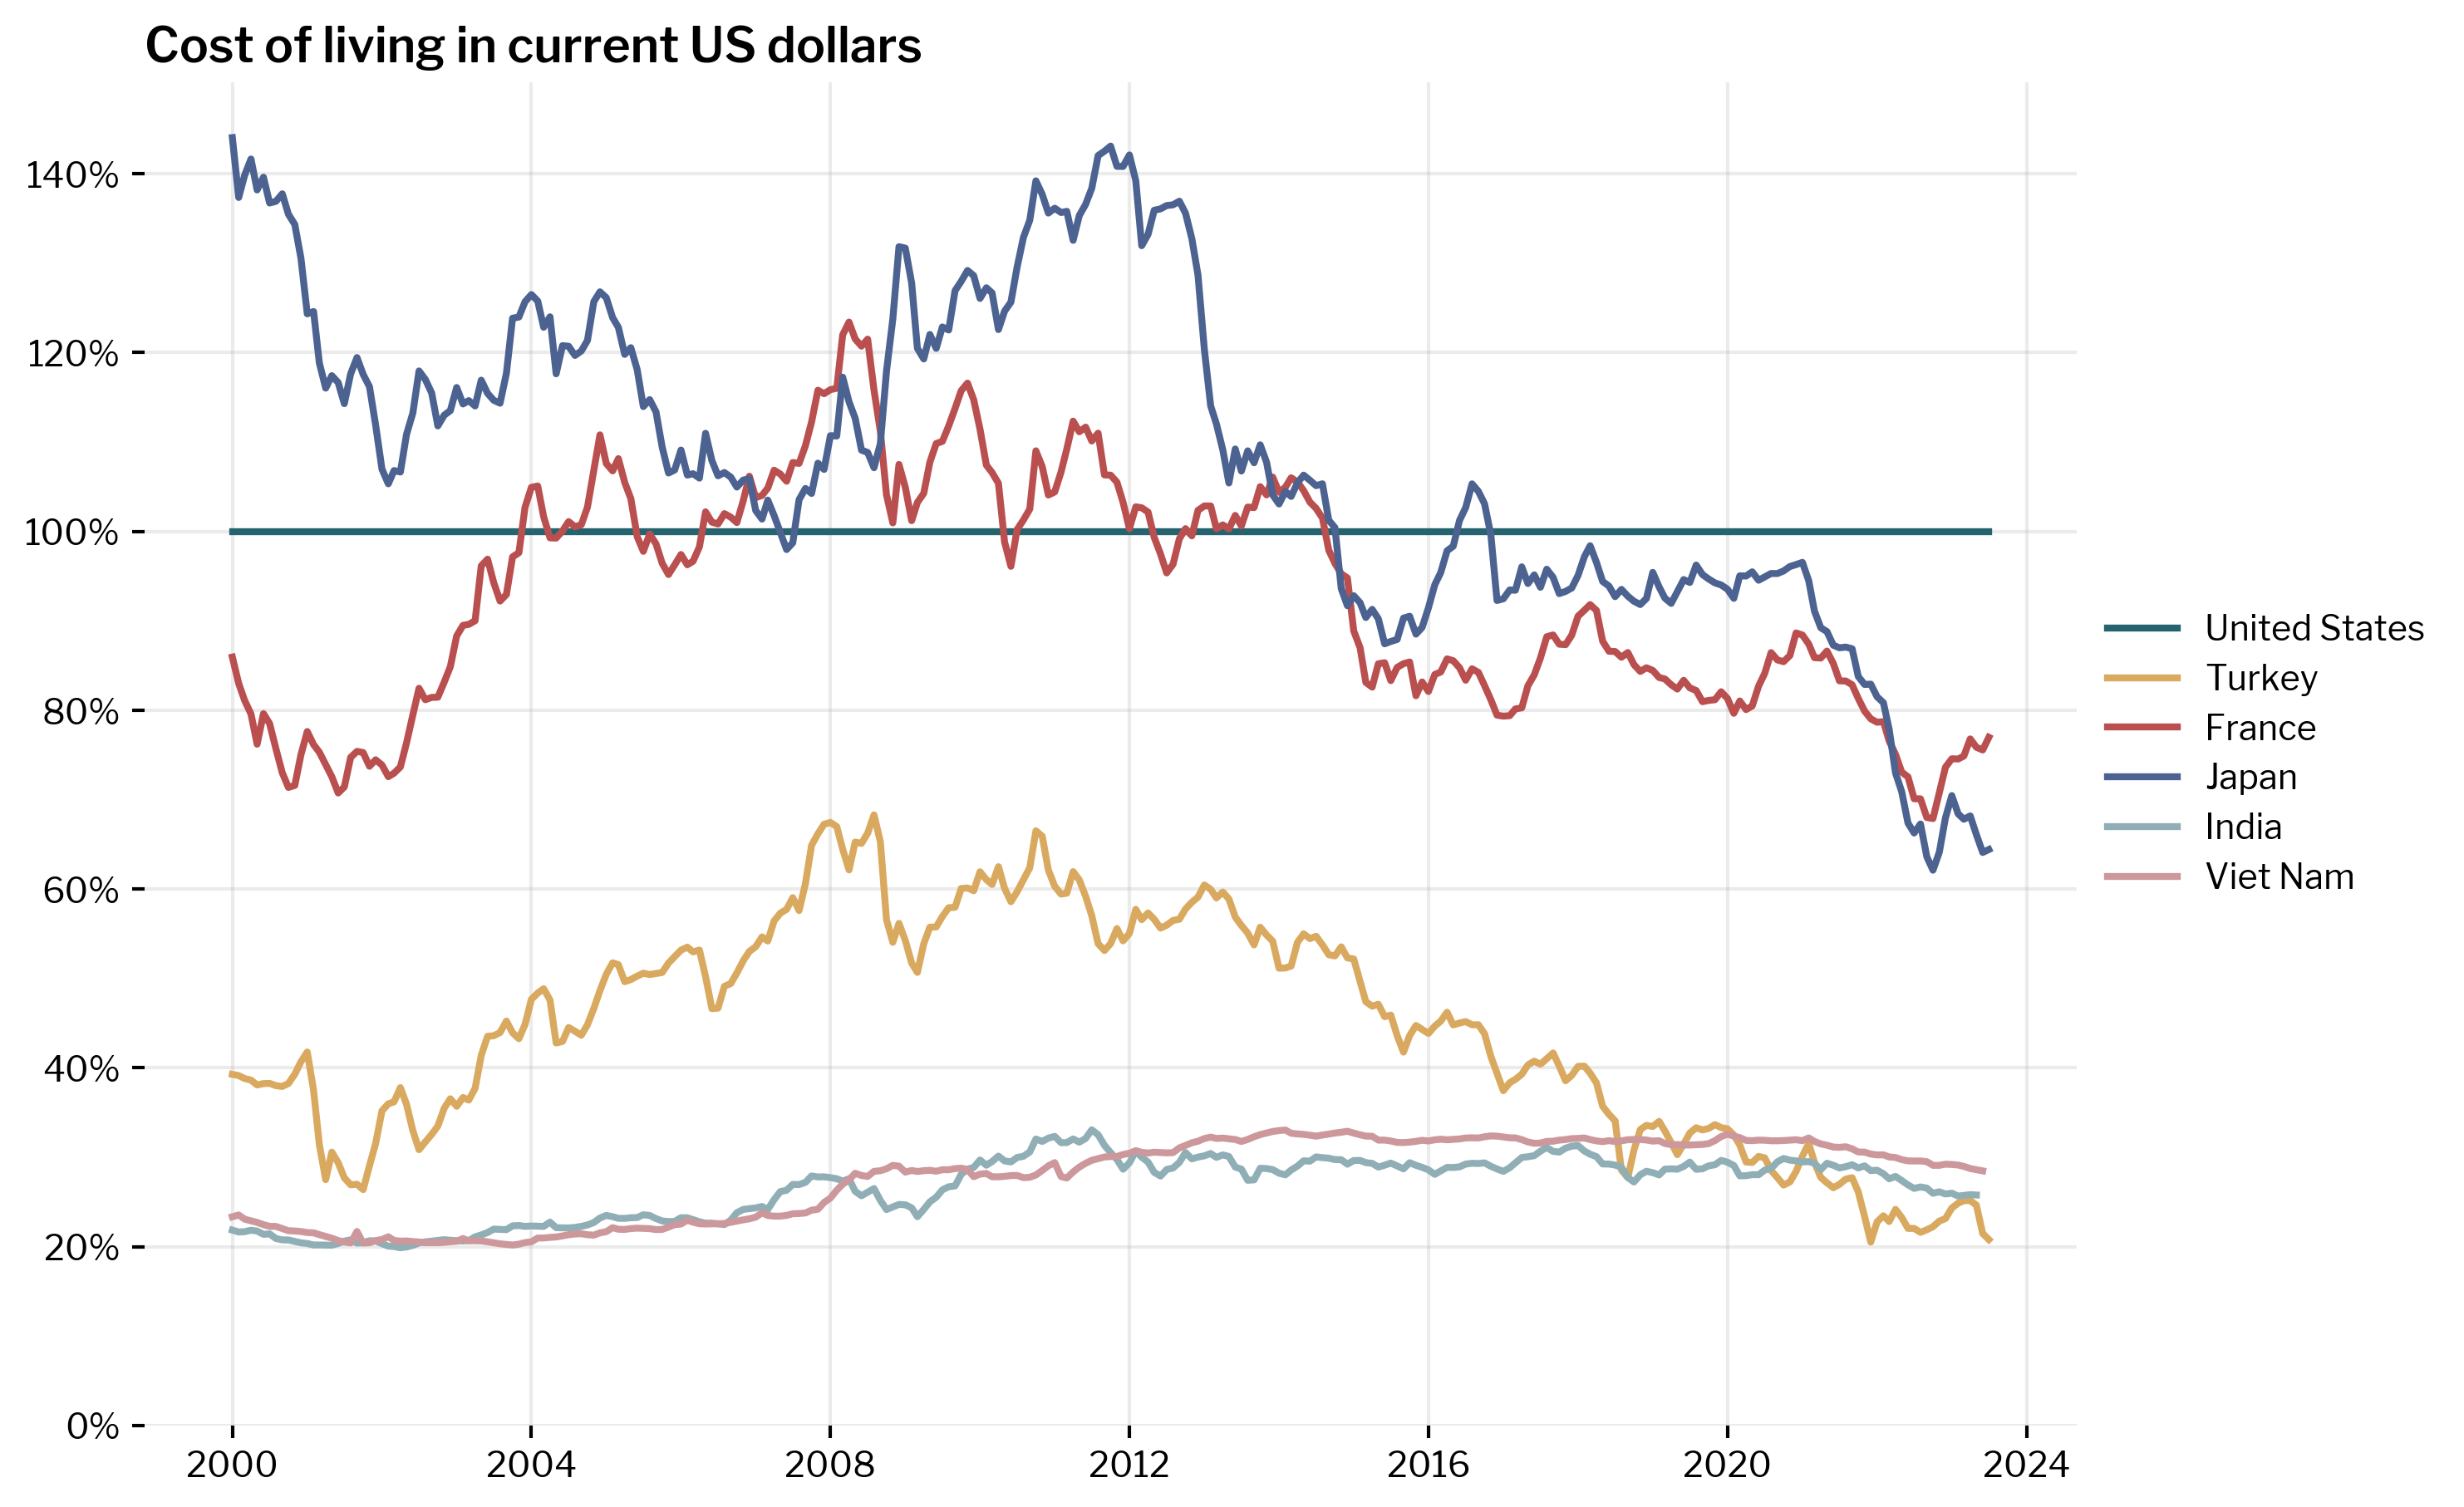

In [282]:
dfe = pd.merge(
    cpi.rename(columns={"value": "cpi"}),
    exr.rename(columns={"value": "exr_x"}),
    on=["date", "country_name"],
    how="outer",
)

# init df to hold all contries using other country's currency
dfall = pd.DataFrame()

# handle Euro
dftmp = dfe.loc[dfe.country_name.str.contains("Euro"), ["date", "country_name", "exr_x"]]
dftmp.rename(columns={"exr_x": "exr_y"}, inplace=True)

# for all countries using the Euro, use the Euro exchange rate
for country in [
    "Austria",
    "Belgium",
    "Cyprus",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Monaco",
    "Netherlands",
    "Portugal",
    "Slovakia",
    "Slovenia",
    "Spain",
]:
    dftmp["country_name"] = country
    dfall = pd.concat([dfall, dftmp])

# Danish krone
dftmp = dfe.loc[dfe.country_name.str.contains("Denmark"), ["date", "country_name", "exr_x"]]
dftmp.rename(columns={"exr_x": "exr_y"}, inplace=True)

for country in ["Greenland", "Faroe Islands"]:
    dftmp["country_name"] = country
    dfall = pd.concat([dfall, dftmp])

# other currencies? TODO: GBP (e.g. Isle of Man), USD (Guam)

# combine all
dfe = dfe.merge(dfall, on=["date", "country_name"], how="left")

# fill nulls and delete duplicate column
dfe["exr"] = dfe.exr_x.fillna(dfe.exr_y)
dfe.drop(columns=["exr_x", "exr_y"], inplace=True)

# remove nulls
dfe = dfe.loc[dfe.exr.notnull()]

# merge ppp
df = pd.merge(dfe, ppp, on="country_name", how="inner")

# merge state dept
df = pd.merge(
    df,
    state_dept,
    on="country_name",
    how="inner", # checked
)

# drop rows where cpi is missing
df = df.loc[df.cpi.notnull()]

# drop duplicate rows
df = df.drop_duplicates()

# adjust cpi relative to 2020 since that's where our PPP measure comes from
df["cpi_2020"] = df.loc[df.date.dt.year == 2020].cpi
df["cpi_2020"] = df.groupby("country_name").cpi_2020.transform("max")
df["cpi_2020"] = df.cpi / df.cpi_2020 * 100

# first, convert 2020 ppp to dollars using exchange rate
# ppp is own_currency, so divide by exr (own_currency per dollar) to get dollars
# this measure will fluctuate over time due to exchange rates and is interpreted as
# the number of dollars needed to buy goods worth $1 in US in 2020 in that year,
# not yet adjusted for inflation.
df["ppp_dollars"] = df.ppp_2020 / df.exr

# next, use cpi to get cpi and ppp-adjusted dollars across time
# this measure fluctuates over time due to both exchange rates and inflation
# and is interpreted as the number of 2020 dollars needed to buy goods worth $1
# in US in 2020 in that year.
df["cpi_ppp_real_dollars"] = df.cpi_2020 * df.ppp_dollars

# finally, divide by US CPI to get cost in current dollars
us_cpi = df.loc[df.country_name == "United States", ["date", "cpi_2020"]].drop_duplicates()
us_cpi = us_cpi.rename(columns={"cpi_2020": "us_cpi"})
df = df.merge(us_cpi, on="date", how="inner").sort_values([
    "country_name", "date"
]).reset_index(drop=True)
df["cpi_ppp_current_dollars"] = df.cpi_ppp_real_dollars / df.us_cpi

_, ax = plt.subplots(figsize=(10, 7))

for country in ["United States", "Turkey", "France", "Japan", "India", "Viet Nam"]:
    dfsub = df.loc[df.country_name == country]
    #     exr_2010 = dfsub.loc[dfsub.date.dt.year == 2010].value.mean()
    plt.plot(dfsub.date, dfsub.cpi_ppp_current_dollars, label=country)
# percent y axis
plt.gca().yaxis.set_major_formatter(
    matplotlib.ticker.PercentFormatter(xmax=1, decimals=0)
)
plt.ylim(0)
add_legend()
plt.title("Cost of living in current US dollars")

In [281]:
df.country_name.sort_values().unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Armenia', 'Aruba', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Benin', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Cote d`Ivoire',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Estonia', 'Eswatini',
       'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR, China',
       'Hungary', 'Iceland', 'India', 'Indonesia',
       '

In [258]:
# where is it currently cheapest and most expensive? Among countries without advisories

dftmp = df.loc[df.advisory_level.between(1, 2)].copy()

ranked_list = dftmp.loc[dftmp.date == dftmp.date.max()].sort_values(
    "cpi_ppp_current_dollars"
)
print("Cheapest 10:")
display(ranked_list.head(10))
print("Most expensive 10:")
display(ranked_list.tail(10))

Cheapest 10:


,date,cpi,country_name,exr,ppp_2020,country_code,advisory_level,cpi_2020,ppp_dollars,cpi_ppp_real_dollars,us_cpi,cpi_ppp_current_dollars
46960,2023-07-01,829.506726,Turkey,26.428835,2.20,TUR,2,293.147917,0.083242,24.402340,117.359506,0.207928
27289,2023-07-01,239.910450,Lao People`s Democratic Republic,17908.523810,2887.17,LAO,2,165.326700,0.161218,26.653581,117.359506,0.227111
23030,2023-07-01,169.255912,Indonesia,15039.750000,4673.93,IDN,2,109.047513,0.310772,33.888890,117.359506,0.288761
758,2023-07-01,197.533583,Algeria,135.042700,37.02,DZA,2,124.681462,0.274136,34.179617,117.359506,0.291239
3185,2023-07-01,234.714707,Bangladesh,108.757173,32.37,BGD,2,119.391888,0.297636,35.535269,117.359506,0.302790
32396,2023-07-01,280.406619,Mongolia,3442.353125,923.80,MNG,1,136.896476,0.268363,36.737940,117.359506,0.313038
2403,2023-07-01,211.753967,Azerbaijan,1.700000,0.50,AZE,2,130.014424,0.294118,38.239537,117.359506,0.325832
4595,2023-07-01,157.828886,Bolivia,6.910000,2.62,BOL,2,104.435664,0.379161,39.597893,117.359506,0.337407
37282,2023-07-01,153.457249,Philippines,54.921050,19.51,PHL,2,113.059701,0.355237,40.163012,117.359506,0.342222
36719,2023-07-01,175.745648,Paraguay,7272.678095,2591.04,PRY,1,117.988930,0.356270,42.035964,117.359506,0.358181


Most expensive 10:


,date,cpi,country_name,exr,ppp_2020,country_code,advisory_level,cpi_2020,ppp_dollars,cpi_ppp_real_dollars,us_cpi,cpi_ppp_current_dollars
48001,2023-07-01,143.147771,United Kingdom,0.775002,0.69,GBR,2,117.915905,0.890320,104.982854,117.359506,0.894541
29070,2023-07-01,130.941851,Luxembourg,0.904311,0.86,LUX,1,112.348918,0.951000,106.843853,117.359506,0.910398
18035,2023-07-01,131.968297,Finland,0.904311,0.84,FIN,1,116.758110,0.928884,108.454740,117.359506,0.924124
7626,2023-07-01,135.746995,Canada,1.321437,1.25,CAN,1,114.814815,0.945940,108.607929,117.359506,0.925429
14732,2023-07-01,126.952951,Denmark,6.738676,6.63,DNK,2,113.942308,0.983873,112.104734,117.359506,0.955225
35599,2023-07-01,142.140983,Norway,10.260000,10.12,NOR,1,115.636042,0.986355,114.058163,117.359506,0.971870
24061,2023-07-01,119.077011,Israel,3.668350,3.85,ISR,2,110.232068,1.049518,115.690558,117.359506,0.985779
48284,2023-07-01,140.189539,United States,1.000000,1.00,USA,1,117.359506,1.000000,117.359506,117.359506,1.000000
22466,2023-07-01,164.051064,Iceland,132.764762,149.69,ISL,1,121.532758,1.127483,137.026108,117.359506,1.167576
44515,2023-07-01,104.478683,Switzerland,0.873980,1.14,CHE,1,105.321071,1.304378,137.378453,117.359506,1.170578


In [248]:
dftmp.head(2)

,date,cpi,country_name,exr,ppp_2020,country_code,advisory_level,cpi_2020,ppp_dollars,cpi_ppp_real_dollars,us_cpi,cpi_ppp_current_dollars
193,2000-01-01,75.335299,Albania,136.624,42.41,ALB,2,61.415826,0.310414,19.064331,64.804933,0.294180
194,2000-02-01,74.873140,Albania,139.520,42.41,ALB,2,61.039059,0.303971,18.554089,65.188848,0.284621


In [261]:
ranked_list.loc[
    ranked_list.groupby(
        ["country_name", "advisory_level", "date"]
    ).exr.transform("count") > 1
]

,date,cpi,country_name,exr,ppp_2020,country_code,advisory_level,cpi_2020,ppp_dollars,cpi_ppp_real_dollars,us_cpi,cpi_ppp_current_dollars
11774,2013-07-01,110.936578,Congo,918.050300,881.85,COD,2,84.788698,0.960568,81.445334,89.68112,0.908166
11776,2013-07-01,110.936578,Congo,918.050300,293.35,COG,2,84.788698,0.319536,27.093030,89.68112,0.302104
11778,2013-07-01,110.936578,Congo,501.491176,881.85,COD,2,84.788698,1.758456,149.097166,89.68112,1.662526
11780,2013-07-01,110.936578,Congo,501.491176,293.35,COG,2,84.788698,0.584955,49.597611,89.68112,0.553044
11782,2013-07-01,126.158506,Congo,918.050300,881.85,COD,2,96.422800,0.960568,92.620684,89.68112,1.032778
11784,2013-07-01,126.158506,Congo,918.050300,293.35,COG,2,96.422800,0.319536,30.810543,89.68112,0.343557
11786,2013-07-01,126.158506,Congo,501.491176,881.85,COD,2,96.422800,1.758456,169.555219,89.68112,1.890646
11788,2013-07-01,126.158506,Congo,501.491176,293.35,COG,2,96.422800,0.584955,56.403043,89.68112,0.628929


In [270]:
dftmp = df.loc[df.advisory_level.between(1, 2) & 
               ~df.country_name.isin(["Congo"])].copy()

ranked_list = dftmp.loc[dftmp.date.isin(
    [
        datetime.date(2013, 7, 1),
        datetime.date(2023, 7, 1)
    ]
)].copy()

# rotate on date
ranked_list = ranked_list.set_index(
    ["country_name", "advisory_level", "date"],
)[[
    "cpi_ppp_real_dollars", "cpi_ppp_current_dollars"
]].unstack("date").reset_index()
ranked_list.columns = [
    "country_name", "advisory_level", "real_cpi_prev", "real_cpi_now",
    "current_cpi_prev", "current_cpi_now"
]

# calculate diff
ranked_list["diff"] = (
    ranked_list.current_cpi_now - ranked_list.current_cpi_prev
) / ranked_list.current_cpi_prev

# keep rows with diff
ranked_list = ranked_list.loc[~ranked_list["diff"].isnull()]

# sort by diff
ranked_list = ranked_list.sort_values(by="diff", ascending=False)
print("Largest increases in price:")
display(ranked_list.head(10))

print("\nLargest decreases in price:")
display(ranked_list.tail(10))

Largest increases in price:


,country_name,advisory_level,real_cpi_prev,real_cpi_now,current_cpi_prev,current_cpi_now,diff
71,Lithuania,1,15.682037,69.355354,0.174864,0.590965,2.379561
0,Albania,2,34.251284,50.790619,0.381923,0.432778,0.133155
4,Armenia,2,33.116912,45.724956,0.369274,0.389614,0.055082
30,Czech Republic,1,57.000193,78.307463,0.635587,0.667244,0.049807
52,Iceland,1,102.840408,137.026108,1.146734,1.167576,0.018175
10,Bangladesh,2,26.731499,35.535269,0.298073,0.302790,0.015825
128,United States,1,89.681120,117.359506,1.000000,1.000000,0.000000
14,Bolivia,2,30.291488,39.597893,0.337769,0.337407,-0.001072
37,Estonia,1,65.065108,81.243309,0.725516,0.692260,-0.045838
104,Serbia,2,41.884634,51.539126,0.467040,0.439156,-0.059703



Largest decreases in price:


,country_name,advisory_level,real_cpi_prev,real_cpi_now,current_cpi_prev,current_cpi_now,diff
81,Mongolia,1,41.325038,36.737940,0.460800,0.313038,-0.320665
7,Azerbaijan,2,43.246514,38.239537,0.482225,0.325832,-0.324315
68,Latvia,1,82.726503,71.696295,0.922452,0.610912,-0.337730
67,Lao People`s Democratic Republic,2,30.767007,26.653581,0.343071,0.227111,-0.338008
86,Namibia,1,54.882090,46.864939,0.611969,0.399328,-0.347470
17,Brazil,2,70.224945,58.954976,0.783052,0.502345,-0.358478
116,Sweden,2,122.083190,99.396826,1.361303,0.846943,-0.377844
89,Norway,1,142.475491,114.058163,1.588690,0.971870,-0.388257
58,Japan,1,95.736868,75.601412,1.067525,0.644187,-0.396561
125,Turkey,2,50.158300,24.402340,0.559296,0.207928,-0.628233


In [244]:
# where are the biggest changes since 2019? Among countries without advisories

dftmp = df.loc[df.advisory_level.between(1, 2)].copy()

ranked_list = dftmp.loc[dftmp.date.isin(
    [
        datetime.date(2019, 7, 1),
        datetime.date(2023, 7, 1)
    ]
)].copy()
# generate diff
ranked_list["diff"] = ranked_list.groupby([
    "country_name", "advisory_level"
]).cpi_ppp_current_dollars.diff()
ranked_list = ranked_list.loc[ranked_list["diff"].notnull()]
# sort by diff
ranked_list = ranked_list.sort_values(by="diff", ascending=False)
print("Cheapest 10:")
display(ranked_list.head(10))
print("Most expensive 10:")
display(ranked_list.tail(10))

Cheapest 10:


,date,cpi,country_name,exr,ppp_2020,country_code,advisory_level,cpi_2020,ppp_dollars,cpi_ppp_real_dollars,us_cpi,cpi_ppp_current_dollars,diff
12706,2019-07-01,124.984300,Congo,584.715742,881.85,COD,2,95.525356,1.508169,144.068355,98.501578,1.462599,1.289943
14449,2023-07-01,159.971331,Czech Republic,21.584000,12.79,CZE,1,132.149201,0.592569,78.307463,117.359506,0.667244,0.116024
31831,2023-07-01,175.506153,Mexico,16.944700,9.70,MEX,2,117.901364,0.572450,67.492681,117.359506,0.575093,0.085012
16945,2023-07-01,166.717470,Estonia,0.904311,0.54,EST,1,136.054104,0.597140,81.243309,117.359506,0.692260,0.077252
1595,2023-07-01,151.629186,Armenia,386.538000,156.71,ARM,2,112.784333,0.405419,45.724956,117.359506,0.389614,0.075774
28787,2023-07-01,163.618141,Lithuania,0.904311,0.46,LTU,1,136.345235,0.508675,69.355354,117.359506,0.590965,0.074055
19163,2023-07-01,174.491700,Georgia,2.597500,0.90,GEO,1,122.298665,0.346487,42.374899,117.359506,0.361069,0.066604
27572,2023-07-01,156.106543,Latvia,0.904311,0.49,LVA,1,132.317851,0.541849,71.696295,117.359506,0.610912,0.058161
475,2023-07-01,137.178900,Albania,93.380000,42.41,ALB,2,111.832774,0.454166,50.790619,117.359506,0.432778,0.050921
41575,2023-07-01,151.471811,Slovakia,0.904311,0.54,SVK,1,128.571429,0.597140,76.775106,117.359506,0.654187,0.050639


Most expensive 10:


,date,cpi,country_name,exr,ppp_2020,country_code,advisory_level,cpi_2020,ppp_dollars,cpi_ppp_real_dollars,us_cpi,cpi_ppp_current_dollars,diff
5384,2023-07-01,214.093148,Brazil,4.800233,2.36,BRA,2,119.914254,0.491643,58.954976,117.359506,0.502345,-0.093347
26196,2023-07-01,128.744433,"Korea, Republic of",1283.315789,824.60,KOR,1,110.383165,0.642554,70.927170,117.359506,0.604358,-0.096937
42418,2023-07-01,195.455212,South Africa,18.184099,6.97,ZAF,2,117.690678,0.383302,45.111061,117.359506,0.384384,-0.100161
24061,2023-07-01,119.077011,Israel,3.668350,3.85,ISR,2,110.232068,1.049518,115.690558,117.359506,0.985779,-0.118050
46960,2023-07-01,829.506726,Turkey,26.428835,2.20,TUR,2,293.147917,0.083242,24.402340,117.359506,0.207928,-0.119157
33910,2023-07-01,187.499486,Namibia,18.184100,7.40,NAM,1,115.161720,0.406949,46.864939,117.359506,0.399328,-0.119857
35599,2023-07-01,142.140983,Norway,10.260000,10.12,NOR,1,115.636042,0.986355,114.058163,117.359506,0.971870,-0.202414
24909,2023-07-01,111.478291,Japan,140.841667,101.24,JPN,1,105.174129,0.718821,75.601412,117.359506,0.644187,-0.298753
12704,2019-07-01,124.984300,Congo,1647.698013,293.35,COG,2,95.525356,0.178036,17.006978,98.501578,0.172657,-0.346373
12708,2019-07-01,124.984300,Congo,584.715742,293.35,COG,2,95.525356,0.501697,47.924763,98.501578,0.486538,-0.976061
